In [1]:
import sys

sys.path.append("../")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [3]:
import neural.binary_modules as bm
import neural.utilities as utils

#### Training preliminaries

In [4]:
def plot_values(values, subplot=None, **kwargs):
    # clear_output(True)
    if subplot:
        plt.subplot(*subplot)
  
    plt.plot(np.arange(len(values)) + 1, values, **kwargs)
    plt.xlabel("n_epoch")
    plt.legend()
    # plt.show()


def matrix_accuracy(A: np.array, B: np.array):
    assert A.shape == B.shape
    return np.sum(np.abs(A - B)) / A.size

In [8]:
def train_over_matrix(matrix, model, criterion, optimizer,
                      batch_size=16, n_epochs=10):
    
    train_loader = DataLoader(utils.matrix_to_ids(matrix), batch_size=batch_size)
    losses_per_epoch = list()
    fact_acc = list()
    intermediate_user_factors = list()
    intermediate_item_factors = list()

    for epoch in tqdm(range(n_epochs)):
        losses_per_batch = list()

        for i, batch in enumerate(train_loader):
            model_output = model(batch)
            target = batch[:, 2].float()

            optimizer.zero_grad()
            train_loss = criterion(model_output, target)
            train_loss.backward()
            optimizer.step()
            losses_per_batch.append(train_loss.detach().numpy())
            
        losses_per_epoch.append(np.array(losses_per_batch).mean())

        clear_output(True)
        plt.figure(figsize=(12, 3))
        plot_values(losses_per_epoch, subplot=(1, 2, 1), label=str(criterion), color="green")
        plot_values(fact_acc, subplot=(1, 2, 2), label="Factorization accuracy", color="maroon")
        plt.show()
        
        if epoch % 10 == 0:
            # Calculating factorization error
            # temp_user_factor = (np.sign(model.user_embedding_b.weight.detach().clone().numpy()) + 1) / 2
            # temp_item_factor = (np.sign(model.item_embedding_b.weight.detach().clone().numpy()) + 1) / 2
            temp_user_factor, temp_item_factor = model.get_factors()
            approx_matrix = utils.bin_matmul_1(temp_user_factor, temp_item_factor.T)
            fact_acc.append(matrix_accuracy(approx_matrix, matrix.numpy()))
            
        if epoch % 20 == 0:
            intermediate_user_factors.append(temp_user_factor)
            intermediate_item_factors.append(temp_item_factor)
            

    user_bin_factor, item_bin_factor = model.get_factors()

    output = {
        "user_bin_factor": user_bin_factor,
        "item_bin_factor": item_bin_factor,
        "losses_per_epoch": losses_per_epoch,
        "fact_acc": fact_acc,
        "iuf": intermediate_user_factors,
        "iif": intermediate_item_factors
    }

    return output

#### Training BinaryNCF over a matrix

In [9]:
n_users = 32
n_items = 32
emb_size = 8

model = bm.NeuralBMF(n_users, n_items, emb_size)
matrix = utils.get_binary_tensor((n_users, n_items))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

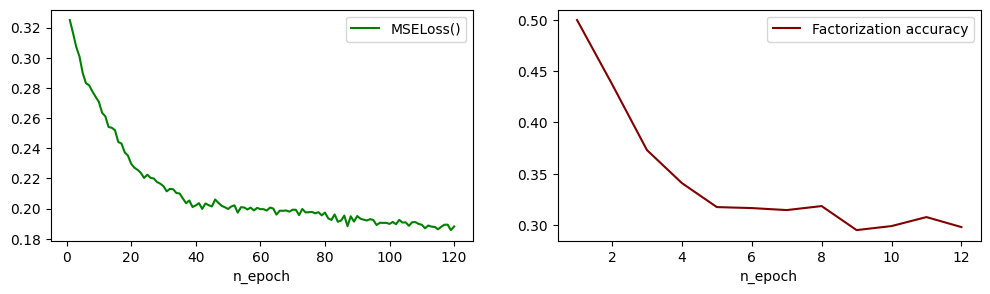

In [7]:
output = train_over_matrix(
    matrix=matrix,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    batch_size=16, n_epochs=120
)

In [10]:
user_factors, item_factors = output["iuf"], output["iif"]

for fact in user_factors:
    print(f"(UserFactor): {int(np.sum(fact))} ones of {fact.size} total cells")
print()
for fact in item_factors:
    print(f"(ItemFactor): {int(np.sum(fact))} ones of {fact.size} total cells")

(UserFactor): 138 ones of 256 total cells
(UserFactor): 122 ones of 256 total cells
(UserFactor): 107 ones of 256 total cells
(UserFactor): 103 ones of 256 total cells
(UserFactor): 96 ones of 256 total cells
(UserFactor): 98 ones of 256 total cells

(ItemFactor): 111 ones of 256 total cells
(ItemFactor): 74 ones of 256 total cells
(ItemFactor): 84 ones of 256 total cells
(ItemFactor): 89 ones of 256 total cells
(ItemFactor): 88 ones of 256 total cells
(ItemFactor): 94 ones of 256 total cells


In [11]:
user_bin_emb, item_bin_emb = output["user_bin_emb"], output["item_bin_emb"]

print(user_bin_emb.shape, item_bin_emb.shape)
print(matrix)
print(utils.bin_matmul_1(user_bin_emb, item_bin_emb.T))
matrix_accuracy(matrix.numpy(), utils.bin_matmul_1(user_bin_emb, item_bin_emb.T))

(32, 8) (32, 8)
tensor([[1, 1, 0,  ..., 0, 1, 1],
        [0, 1, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 1],
        ...,
        [0, 1, 1,  ..., 1, 1, 1],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 1,  ..., 0, 0, 0]], dtype=torch.int8)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 0 1 1]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 0 1 ... 0 0 0]
 [0 1 1 ... 1 1 1]]


0.31640625

In [14]:
# Explore raw_embeddings

raw_uw = model.get_factors(raw=True)[1]
np.stack((raw_uw.min(axis=1), raw_uw.max(axis=1)), axis=1)

array([[-1.4327576e+00,  8.2961822e-01],
       [-7.2003829e-01,  5.4396367e-01],
       [-1.6414427e+00,  1.4144045e+00],
       [-2.1674578e+00,  1.0305730e+00],
       [-6.9638550e-01,  8.7268400e-01],
       [-9.0516412e-01,  1.0958638e+00],
       [-7.0574933e-01,  4.6880636e-01],
       [-5.3257459e-01,  6.6789967e-01],
       [-1.6011730e+00,  6.6594201e-01],
       [-8.0779344e-01,  1.3710307e+00],
       [-1.5756570e+00,  1.6084577e+00],
       [-2.2177448e+00, -8.9082196e-02],
       [-7.6921189e-01, -1.2985396e-03],
       [-1.1964043e+00,  5.8822310e-01],
       [-1.3073149e+00,  1.0188907e+00],
       [-8.3052009e-01,  5.5646187e-01],
       [-1.1007261e+00,  7.1325326e-01],
       [-1.4961059e+00,  6.6733778e-01],
       [-1.9228429e-01,  1.1849840e+00],
       [-7.9638481e-01,  1.0959316e+00],
       [-1.2436811e+00,  5.6156707e-01],
       [-4.5514578e-01,  1.0236294e+00],
       [-1.0142059e+00,  4.5517656e-01],
       [-1.2729325e+00,  3.8023490e-01],
       [-1.34239

#### NeuralBMF_beta

In [11]:
n_users = 32
n_items = 32
emb_size = 8

model = bm.NeuralBMF_beta(n_users, n_items, emb_size)
matrix = utils.get_binary_tensor((n_users, n_items))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

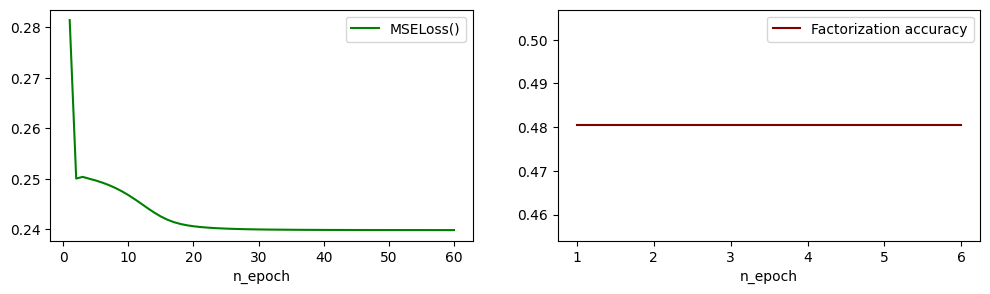

In [12]:
output = train_over_matrix(
    matrix=matrix,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    batch_size=16, n_epochs=60
)

NOTE: NeuralBMF_beta shows more smooth decrease of loss, but accuracy stays constant for some reason...